<img src="../../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Use case: Manipulating outputs from the Data Transfer Service

The [Fink data transfer service](https://lsst.fink-portal.org/download) was developed due to the need to transfer large quantities of data for statistical and population studies, as well as to enable training of machine learning models (see [Fraga *et al*, 2024](https://www.aanda.org/articles/aa/full_html/2024/12/aa50370-24/aa50370-24.html)). 

The service has been extensively used during its operation with ZTF data. 

For LSST, we continue to provide the community with easy access to large volumes of data, however, the post-processing of the results requires some fine tunning, given the complexity of the survey. 

You can discover details on how to fetch data from Fink in the documentation. 

In this notebook, we provide you with a few examples on how to manipulate the resulting parquet files. 

## Environment set up

In order to run this notebook, you will need to install the [fink-client](https://github.com/astrolabsoftware/fink-client) and [pyarrow](https://pypi.org/project/pyarrow/). 

Then you can import the following libraries

In [71]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pylab as plt
import pyarrow.parquet as pq
import pyarrow.compute as pc
import pyarrow as pa

from fink_utils.data.utils import extract_history  

### Case 1: Reading the data into pandas

Suppose that the result of your query to the data transfer service is store in a directory named ... 

In [97]:
dirname = 'ftransfer_lsst_2026-02-24_123456/'

In [98]:
# read each individual file name
fns = glob.glob(dirname + "*.parquet")
pdf = pd.DataFrame()

for fn in fns[:20]:

    # read each file as a table
    table = pq.read_table(
        fn,
    )
    # transfer to pandas, allowing the existance of Nones
    df = table.to_pandas(integer_object_nulls=True)
    
    # Casting to str diaObjectId 
    # this will preserve the information in the name, even in case of Nones
    diaObjectId = pc.struct_field(table['diaObject'], 'diaObjectId')
    diaObjectId_str = pc.cast(diaObjectId, pa.string())

    # add new column to the data frame
    df['diaObjectId'] = diaObjectId_str.to_pandas()

    # concatenate all files
    pdf = pd.concat((pdf, df))
    
data = pdf.reset_index()

The final data frame will contain an extra column, containing directly the `diaObjectId`

In [99]:
data.keys()

Index(['index', 'diaSourceId', 'observation_reason', 'target_name',
       'diaSource', 'prvDiaSources', 'prvDiaForcedSources', 'diaObject',
       'ssSource', 'mpc_orbits', 'brokerIngestMjd', 'lsst_schema_version',
       'brokerStartProcessTimestamp', 'fink_broker_version',
       'fink_science_version', 'publisher', 'lc_features', 'clf', 'xm', 'pred',
       'misc', 'brokerEndProcessTimestamp', 'timestamp', 'year', 'month',
       'day', 'tns_type_recomputed', 'diaObjectId'],
      dtype='object')

This casting string strategy should be employed for every identification column you intent to use (`diaSourceId`, `diaObjectId`, `visit`, etc.)

### Case 2: accessing alert history

Now that your data is available within a pandas data frame, you are free to explore the potential of the alert package. Important things to keep in mind:

1.  An alert is one point --> `diaSource`
2.  The alert package contains the previous photometric history of that position --> `prvDiaSources` ...
3.  Starting from the second alert, it also contains 30 days of forced photometry preceeding the first alert --> `prvDiaForcedSources`

You can use any information contained in these fields for the construction of your model or filter.

Let's illustrate this task by separating 1 alert:

In [106]:
# get one alert
indx = np.random.choice(np.arange(data.shape[0]))
alert = data.iloc[indx]

In the example below, we consider that the user chose to download the pre-defined *medium package*, which contains all fields, except the image stamps. 

In this case, each line in our data frame is now a dictionary containing all the fields available in the alert package. 

In [107]:
alert

index                                                                        637
diaSourceId                                                   170028487944962094
observation_reason                                                  alert_edfs_a
target_name                                                  lowdust, ddf_edfs_a
diaSource                      {'apFlux': -547.3768310546875, 'apFluxErr': 53...
prvDiaSources                  [{'apFlux': 210.23365783691406, 'apFluxErr': 5...
prvDiaForcedSources            [{'band': 'i', 'dec': -49.368460822324195, 'de...
diaObject                      {'dec': -49.36845892168718, 'decErr': 6.489977...
ssSource                       {'designation': None, 'diaDistanceRank': None,...
mpc_orbits                     {'a': None, 'a1': None, 'a1_unc': None, 'a2': ...
brokerIngestMjd                                                     61090.061299
lsst_schema_version                                                   lsst.v10_0
brokerStartProcessTimestamp 

In order to reconstruct the light curve from this, we will use the function below

In [108]:
def extract_field(alert: dict, field: str, get_forced_photometry=False) -> np.array:
    """Concatenate current and historical observation data for a given field.

    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    field: str
        Name of the field to extract.
    get_forced_photometry: bool (optional)
        If True, also concatenate forced photometry.
        Default is False.

    Returns
    -------
    data: np.array
        List containing previous measurements and current measurement at the
        end. 
    """
    if get_forced_photometry and alert['prvDiaForcedSources'] is not None:
        fphot = extract_history(alert["prvDiaForcedSources"], field)
    else:
        fphot = []
    
    data = np.concatenate([
            fphot, [alert['diaSource'][field]],
            extract_history(alert["prvDiaSources"], field),
            ])

    return data

Let's use it to gather the entire light curve information in a single data frame

In [109]:
mjd = extract_field(alert, 'midpointMjdTai')
psfFlux = extract_field(alert, 'psfFlux')
psfFluxErr = extract_field(alert, 'psfFluxErr')
band = extract_field(alert, 'band')

lc = pd.DataFrame()
lc['cmidpointMjdTai'] = mjd
lc['cpsfFlux'] = psfFlux
lc['cpsfFluxErr'] = psfFluxErr
lc['cband'] = band

We can now plot the entire photometric history for this source

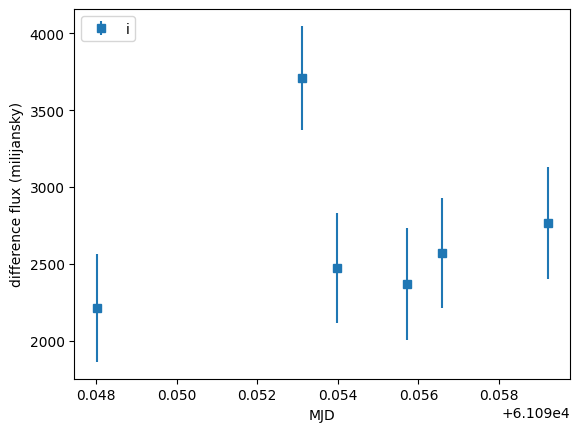

In [110]:
# all lsst bands
all_bands = ['u', 'g', 'r', 'i', 'z', 'y']
symbols = ['o', '<', '>', 's', '*', 'p']

# get unique filters
lc_bands = np.unique(lc['cband'])

plt.figure()

for i in range(len(all_bands)):
    if all_bands[i] in lc_bands:
        flag = lc['cband'] == all_bands[i]        # identify one filter at a time
        
        mjd = lc['cmidpointMjdTai'][flag]         # get observation days (MJD)
        flux = lc['cpsfFlux'][flag]               # get difference flux
        fluxerr = lc['cpsfFluxErr'][flag]         # get difference flux error

        plt.errorbar(mjd, flux, yerr=fluxerr, fmt=symbols[i], label=all_bands[i])

plt.xlabel('MJD')
plt.ylabel('difference flux (milijansky)')
plt.legend(loc='upper left')
plt.show()
